<a href="https://colab.research.google.com/github/elyober/G15PracticaProfesionalizanteISPC/blob/main/ModeloRegresionLogistica_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center>Modelo de regresión logística para analisis de sentimientos<center>**

##   Vamos a entrenar un modelo de regresion logística para la clasificacion de sentimientos en los comentarios de redes sociales y de ventas.
##   Nuestra meta es medir el sentimiento asociado por los clientes hacia la marca . Para ello este modelo será entrenado con el data set data_sentimientos.csv el cual es una pequeña modificación del data set propuesto por Amazon Home_and_Kitchen_5.json el cual posee cerca de 7 millones de rewies que los usuarios de amazon han hecho sobre articulos de cocina. Link  [https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/]


### Citacion del artículo:
### Justifying recommendations using distantly-labeled reviews and fined-grained aspects
###Jianmo Ni, Jiacheng Li, Julian McAuley
###Empirical Methods in Natural Language Processing (EMNLP), 2019




In [1]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np


In [4]:
#cargamos el dataset
df = pd.read_csv("/content/drive/MyDrive/datasets/data_sentimientos.csv")

## una ves cargado el data set vamos a verificar que tan representadas estan las etiquetas de sentimiento.

In [ ]:
#Agrupando y contando las etiquetas
df2= df.groupby(["sentimiento_marca"])["sentimiento_marca"].count()
print(df2)

sentimiento_marca
Excelente    4688044
Neutra        513982
Pesima        374016
Positiva     1033449
negativa      289464
Name: sentimiento_marca, dtype: int64


#Graficámos para ilustrar los resultados.


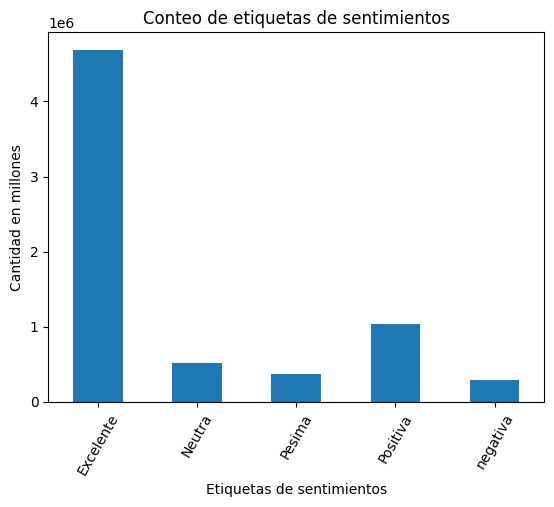

In [ ]:
import matplotlib.pyplot as plt
#rot es un parametro de rotacion para las etiquetas.
df2.plot(kind='bar', rot=60)
plt.xlabel("Etiquetas de sentimientos")
plt.ylabel("Cantidad en millones")
plt.title("Conteo de etiquetas de sentimientos\n")
plt.show()


## Como pudimos observar la muestra posee considerablemente más etiquetas asociados con un sentimiento excelente, el cual esta sobre representado. Por ello decidimos decidimos igualar las etiquetas de sentimiento en n muestras aleatorias de cada una.  

In [ ]:
df["reviewText"] = df["reviewText"].astype(str)
df["sentimiento_marca"]= df["sentimiento_marca"].astype(str)
#como la muestra posee considerablemente mas etiquetas de excelente, dejamos cada etiqueta con un 20% en un nuevo conjunto
#para abordar el desequlibrio de clases y que todas las etiquetas esten bien representadas.

#obteniendo varios valores aleatorios para cada etiqueta.
excelente_df = df.loc[df["sentimiento_marca"] == "Excelente"].sample(n=90000, random_state=42)
negativa_df = df.loc[df["sentimiento_marca"] == "negativa"].sample(n=90000, random_state=42)
pesimo_df = df.loc[df["sentimiento_marca"] == "Pesima"].sample(n=90000, random_state=42)
positivo_df = df.loc[df["sentimiento_marca"] == "Positiva"].sample(n=90000, random_state=42)
#concatenando y redistribuyendo la muestra
combinado_df = pd.concat([excelente_df, negativa_df, pesimo_df, positivo_df])
#frac=1 para tomar el 100% de los datos de forma aleatoria, reset_index(drop=True ) para descartar el indice anterior y crear uno nuevo.
combinado_df = combinado_df.sample(frac=1).reset_index(drop=True)
print(combinado_df.head())

   Unnamed: 0.1  Unnamed: 0  overall  \
0       6566423     6566423      5.0   
1       4180437     4180437      2.0   
2       2449065     2449065      4.0   
3       4287169     4287169      2.0   
4       3235748     3235748      2.0   

                                          reviewText        summary  \
0                           item as described A+++++     Five Stars   
1              colors not as I had thought they'd be      Two Stars   
2  Hostess Set\n\nRequested by my daughter  Haven...    Hostess Set   
3  This did not work it was uncomfortable and did...      Two Stars   
4  No instruction sheet was included, and I find ...  Dissappointed   

  sentimiento_marca  
0         Excelente  
1          negativa  
2          Positiva  
3          negativa  
4          negativa  


In [ ]:
combinado_df.iloc[0]["reviewText"]

In [ ]:
!pip install bs4

In [ ]:
#aplico esta funcion para limpiar la reseña en caso de que contenga codigo HTML.
from bs4 import BeautifulSoup
def limpiar_html(texto_html):
    soup = BeautifulSoup(texto_html, 'html.parser')
    texto_limpio = soup.get_text()
    return texto_limpio

In [ ]:
combinado_df["resenia"]= combinado_df["reviewText"].apply(limpiar_html)

<ipython-input-5-301fc73ace60>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(texto_html, 'html.parser')
<ipython-input-5-301fc73ace60>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(texto_html, 'html.parser')


In [ ]:
combinado_df.tail()

## Dividimos el data set para el entrenamiento.

In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(combinado_df["resenia"], combinado_df["sentimiento_marca"], test_size=0.2, random_state=42)

In [ ]:
!pip install nltk

## tokenizer_porter es utilizado para declinar palabras, es decir, para devolver los verbos a su forma raiz para el análisis. De esta manera palabras como corriendo, leyendo serán devueltas como correr, leer. Esta función devuelve una lista con dichas palabras.
## Stop.words es utilizado para no contar palabras vacias, es decir, palabras que no agregan valor o contexto al análisis.  

In [5]:
from nltk.stem.porter import PorterStemmer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
porter = PorterStemmer()
stop = stopwords.words('english')
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split() if word not in stop]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

# preprocesamiento de texto
def preprocesado(text):
    # Tokenización de NLTK.
    tokens = word_tokenize(text)
    # Eliminación de palabras vacias.
    stop_words = set(stopwords.words('english'))
    tokens_filtrado = [word for word in tokens if word.lower() not in stop_words]
    porter = nltk.PorterStemmer()
    stemmed_tokens = [porter.stem(word) for word in tokens_filtrado]
    # Reunir los tokens procesados en un solo texto
    texto_preprocesado = ' '.join(stemmed_tokens)

    return texto_preprocesado

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Configuración inicial de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# preprocesamiento de texto con lematización
def preprocesado_lematizacion(text):
    # Tokenización de NLTK.
    tokens = word_tokenize(text)
    # Eliminación de palabras vacías.
    stop_words = set(stopwords.words('english'))
    tokens_filtrado = [word for word in tokens if word.lower() not in stop_words]

    # Lematización con WordNetLemmatizer.
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens_filtrado]

    # Reunir los tokens procesados en un solo texto
    texto_preprocesado = ' '.join(lemmatized_tokens)

    return texto_preprocesado


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Utilizamos TfidfVectorizer para la transformacion del texto.
tfidf = TfidfVectorizer(strip_accents='unicode',
                        lowercase=True,# True para que transformar las oraciones en minuscula.
                        preprocessor= None)
param_grid = [{'vect__ngram_range': [(1, 3)],
                   'vect__stop_words': [stopwords.words('english')],
                   'vect__tokenizer': [preprocesado_lematizacion],
                   'clf__penalty': ['l2'],
                   'clf__C': [1.0] #se probo clf__C con 0.5, 1.0, 10.0
                    },
                  ]
lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=1, max_iter=1000, solver="newton-cg", multi_class="multinomial", class_weight="balanced"))]) # max_iter=1000 para que el algoritmo converga

#configuramos y realizamos una búsqueda de hiperparámetros utilizando la técnica de validación cruzada mediante GridSearchCV
gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy', #scoring= 'accuracy' evaluará la precisión del modelo.
                           cv=5, # volver a probar 10
                           verbose=2,
                           n_jobs=1)

In [ ]:
gs_lr_tfidf.fit(X_train, y_train)

In [ ]:
print('El mejor conjunto de parametros es : %s ' % gs_lr_tfidf.best_params_)
print('Precision de GridSearchCV: %.3f' % gs_lr_tfidf.best_score_)
#con 90000 gsv 0.570 test de precision 0.572 solver="newton-cg", class_weight="balanced" (clasifica bien)(Candidato)
#con 90000 gsv 0.570 test de precision 0.571 solver="newton-cg", class_weight="balanced" CV=5 C=1.0 con lematizacion entrenamiento 80-20 max_iter=10000(clasifica bien 2° candidato)
#con 40000 gsv 0.563 test de precision 0.567 solver="saga", class_weight="balanced" multi_class="multinomial"CV=5 C=1.0 con lematizacion entrenamiento 80-20 max_iter=1000, L1 como penalizacion. Clasifica bien, 3° candidato.

El mejor conjunto de parametros es : {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 3), 'vect__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any'

In [ ]:
clf = gs_lr_tfidf.best_estimator_
print('Test de precision: %.3f' % clf.score(X_test, y_test))

Test de precision: 0.572


##<center>Reporte del modelo. <center>

In [ ]:
from sklearn.metrics import classification_report
y_pred = gs_lr_tfidf.predict(X_test)
report = classification_report(y_test, y_pred)
print("Informe de Clasificación:")
print(report)

Informe de Clasificación:
              precision    recall  f1-score   support

   Excelente       0.65      0.65      0.65     17946
      Pesima       0.61      0.61      0.61     18033
    Positiva       0.54      0.54      0.54     18022
    negativa       0.49      0.49      0.49     17999

    accuracy                           0.57     72000
   macro avg       0.57      0.57      0.57     72000
weighted avg       0.57      0.57      0.57     72000



##  Dado que el modelo esta entrenado con reseñas en ingles, hacemos una prueba con oraciones en dicho idioma.

In [ ]:
x_p = ["Very bad, when cooking on low heat it burns, when cooking if something is a little too much it gets stained and can not be cleaned, you have to leave the handle well outside the fire because it burns. The battery is not even a month old and that's how they are. Deplorable I would never buy again this brand of pots hudson. Very bad and the company that distributes them is clearly not responsible. They are not good for anything these pots, they burn even to fry an egg! very bad and more for what they cost.",
       "The truth is that I am very happy with my purchase. Besides being very nice the material is phenomenal. I tried it and I'm more than happy haha. I recommend it, the truth is that it is not bad money.",
       "Good design, good quality but the pancake holder sticks.",
       "After the first use, the pans were stained. One of them was also stained at the bottom by the fire and the handle also came loose.",
       "I would not buy them again. I take great care of them and wash them every time I use them, and yet they stain in a way that they just don't come out anymore. I have had them for a month and they are like that. I always put oil on them, I don't know why the stain is so impregnated. Anyway. It fulfills its function but they stain for nothing. In a few months you won't even see their granite details.",
       "Very nice product, they are very nice and the food does not burn or stick. Excellent.",
       "I was fascinated by the cookware set, love the color!!! I highly recommend it.",
       "Very very beautiful, practical and very good quality!!! I loved it!!!."]
y_p = gs_lr_tfidf.best_estimator_.predict(x_p)
print(y_p)

['Pesima' 'Positiva' 'Positiva' 'negativa' 'Pesima' 'Excelente'
 'Excelente' 'Excelente']


In [ ]:
!pip install joblib

## Serilizamos el modelo con tres entrenamientos diferentes. para luego llevar a cabo el analisis con el modelo que más se ajuste a nuestras necesidades.

In [ ]:
import joblib
# Guardar el mejor estimador del GridSearchCV en un archivo
joblib.dump(gs_lr_tfidf.best_estimator_, "Regresion_en_l2.pkl")


['Regresion_en_l2.pkl']

# <center>Análisis de sentimientos sobre el data set final.<center>  

## Llevaremos a cabo el análisis de sentimientos sobre la marca H mediante un data set con Tweets sobre dicha marca.

In [8]:
import joblib

### Cargamos el modelo entrenado con penalizacion L1

In [10]:
modelo = joblib.load('Regresion_en_l1.pkl')

### Definimos la función para aplicarla al data set.

In [9]:
import pandas as pd
def sentimientos(textos):
    if isinstance(textos, str):
        textos = [textos]
    return modelo.predict(textos)

In [14]:
df_H = pd.read_csv("H.csv")
df_H.tail()

,User_ID,User_Name,User_Age,User_Location,Tweet,Unnamed: 5
206,216,User216,54,Salta,Hudson kitchen utensils are not as good as the...,NaN
207,217,User217,31,Santiago del Estero,I like cooking with Hudson products because th...,NaN
208,218,User218,49,Jujuy,The Hudson kitchen scale has helped me be more...,NaN
209,219,User219,30,La Pampa,Hudson products have improved organization in ...,NaN
210,220,User220,42,Chubut,The quality of Hudson products is unrivaled. M...,NaN


In [15]:
#La columna Unnamed: 5, nos quedo de la limpieza del data set y es irrelevante
# para el analisis. Por lo tanto la descartamos mediante este codigo.
df_H = df_H[["User_ID","User_Name","User_Age","User_Location","Tweet"]]
df_H.head()

,User_ID,User_Name,User_Age,User_Location,Tweet
0,1,User1,32,Buenos Aires,Today I cooked with my new Hudson utensils and...
1,2,User2,45,Cordoba,I hate it when I burn dinner. Cooking is not m...
2,3,User3,28,Santa Fe,I'm impressed by how easy it is to use Hudson ...
3,4,User4,54,Mendoza,I don't know what I did wrong but my cake coll...
4,6,User6,29,Tucuman,I don't know how I lived without Hudson produc...


### <center>Aplicamos nuestro modelo al data set de H.<center>

In [16]:
df_H["Sentimiento_Marca"]= df_H["Tweet"].apply(sentimientos)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ', "'", 'c', 'e', 'g', 'h', 'l', 'n', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


In [17]:
df_H.head()

,User_ID,User_Name,User_Age,User_Location,Tweet,Sentimiento_Marca
0,1,User1,32,Buenos Aires,Today I cooked with my new Hudson utensils and...,[Excelente]
1,2,User2,45,Cordoba,I hate it when I burn dinner. Cooking is not m...,[Pesima]
2,3,User3,28,Santa Fe,I'm impressed by how easy it is to use Hudson ...,[Excelente]
3,4,User4,54,Mendoza,I don't know what I did wrong but my cake coll...,[Pesima]
4,6,User6,29,Tucuman,I don't know how I lived without Hudson produc...,[Excelente]


# <center>Sentimientos asociados a H en todo el país<center>

## Estos son los resultados de los sentimientos asociados a los Tweets entregados por el modelo

<Axes: title={'center': 'Sentimientos en Tweets\n sobre la marca H'}, xlabel='Sentimientos expresados', ylabel='Total'>

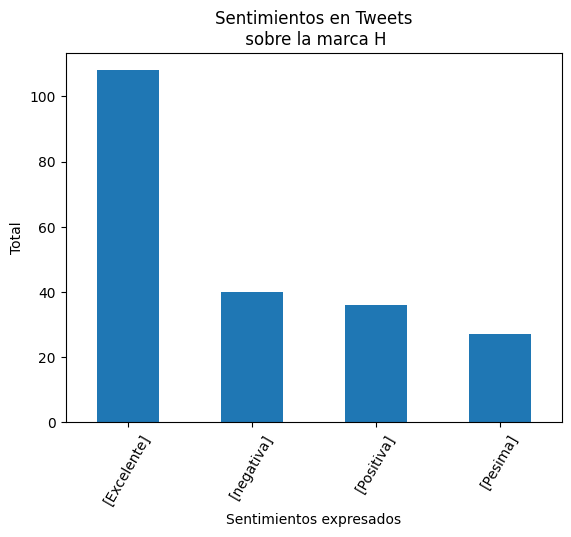

In [20]:
df_H["Sentimiento_Marca"].value_counts().plot(kind="bar", rot=60, title="Sentimientos en Tweets\n sobre la marca H", xlabel="Sentimientos expresados", ylabel="Total")

## Nuestro modelo predice que más de la mitad, el 51%, de los tweets en todo el país sobre la marca H son excelentes

<Axes: title={'center': 'Sentimientos en Tweets\n sobre la marca H\n '}, ylabel='Sentimiento_Marca'>

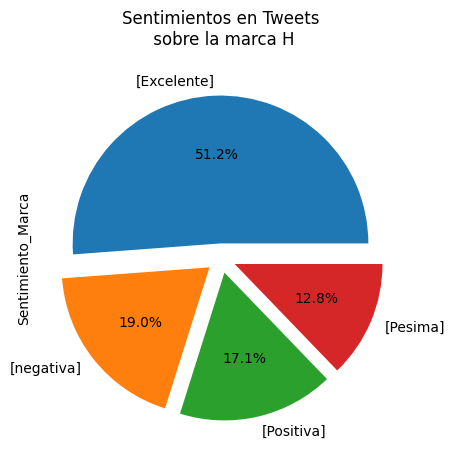

In [39]:
df_H["Sentimiento_Marca"].value_counts().plot(kind="pie", title="Sentimientos en Tweets\n sobre la marca H\n ", explode = (0.1, 0.1, 0.1, 0.1), autopct='%1.1f%%')

## Tweets que nombran a la marca H por Provincias  

<Axes: title={'center': 'Tweets citando a H por provincias'}, xlabel='Provincia', ylabel='Total'>

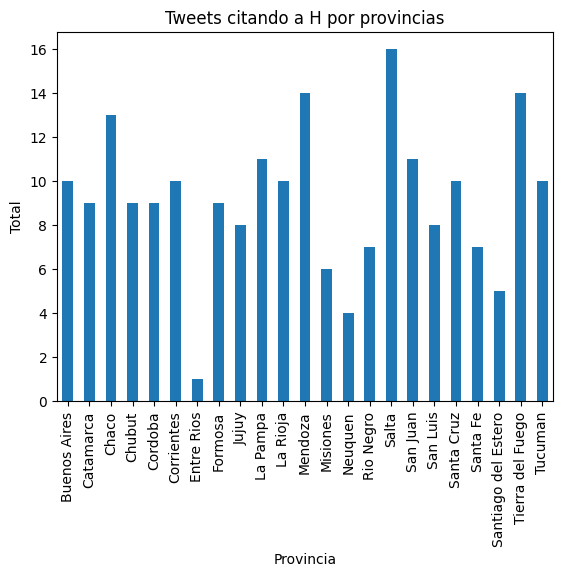

In [26]:
df_H.groupby(["User_Location"])["Sentimiento_Marca"].count().plot(kind="bar", title="Tweets citando a H por provincias", xlabel="Provincia", ylabel="Total")

In [ ]:
df_H_exc = df_H[df_H["Sentimiento_Marca"]=="Excelente"]
df_H_exc.tail()

<Axes: title={'center': 'Sentimiento excelente de H\n por provincias'}, xlabel='Provincia', ylabel='Total'>

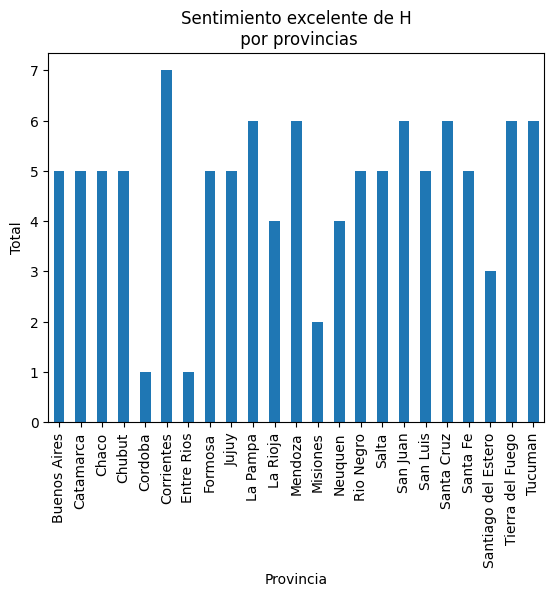

In [42]:
df_H_exc.groupby(["User_Location"])["Sentimiento_Marca"].count().plot(kind="bar", title="Sentimiento excelente de H\n por provincias", xlabel="Provincia", ylabel="Total")

<Axes: title={'center': 'Tweets citando a H por edad'}, xlabel='Edad', ylabel='Total'>

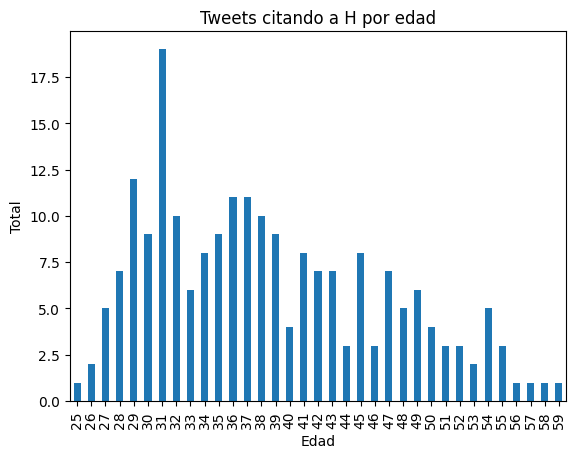

In [28]:
df_H.groupby(["User_Age"])["Sentimiento_Marca"].count().plot(kind="bar", title="Tweets citando a H por edad", xlabel="Edad", ylabel="Total")

In [ ]:
df_edad_31 = df_H[df_H["User_Age"]==31]
df_edad_31.head()

## Dado que la mayoria de los Tweets fueron hechas por personas de 31 años, decidimos graficar los sentimientos asociados a estos tweets y notamos mediante el gráfico que la marca H tiene una muy buena aceptación en este publico que es quien más lo cita en dicha red social.     

<Axes: ylabel='Sentimiento_Marca'>

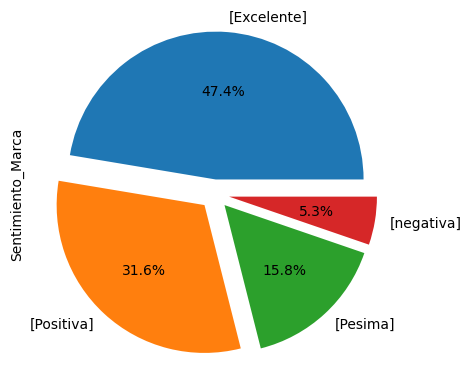

In [36]:
df_edad_31["Sentimiento_Marca"].value_counts().plot(kind="pie", explode = (0.1, 0.1, 0.1, 0.1), autopct='%1.1f%%')

#<center> Obteniendo Topicos de Tweets de la marca H<center>
## Usaremos un modelo de aprendizage no supervisado para hacernos con los topicos de los Tweets que citan a la marca. En este caso decidimos usar LatentDirichletAllocation para el modelado de temas.   

## Topicos para el sentimiento Excelente

In [43]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df = .1, max_features= 5000)
df_H_exc = df_H[df_H["Sentimiento_Marca"]=="Excelente"]
count_excelente = count.fit_transform(df_H_exc["Tweet"].values)

In [44]:
#n_components= 10 para decirle que cree 10 topicos.
lda = LatentDirichletAllocation(n_components= 10, random_state=123, learning_method='batch')
topics_excelente = lda.fit_transform(count_excelente)
print(lda.components_.shape)

(10, 121)


In [47]:
#n_palabras_top va a ser usada para la cantidad de palabras a traer de las listas.
n_palabras_top = 10
nombres_caracterisiticos = count.get_feature_names_out()
lista=[]
for topics_idx, topics in enumerate(lda.components_):
  print(f"Palabra Top N°{topics_idx+1}")
  lista.append([nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]])
  print(" ".join( [nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]]))

Palabra Top N°1
baking fun breeze lovetocook love easy clean expected easily stain
Palabra Top N°2
organization place improved scale helped precision blog share happy new
Palabra Top N°3
confidence try given elaborate success loves rain rainy day share
Palabra Top N°4
cutting knives sharp knife excited home just gourmet acquired try
Palabra Top N°5
finally enjoy new love level loveforcooking thank taken slow simplified
Palabra Top N°6
durability don impressed wear happy lived amazing know blog share
Palabra Top N°7
time colorful lifesaver washing easier dishes brings pans quality surprised
Palabra Top N°8
smoothies blender turned master best day smooth ve friends quality
Palabra Top N°9
chef like professional thanks professionalchef feel secret home thing thebest
Palabra Top N°10
efficiency efficient time happy easy new cooker quick changed pressure


In [ ]:
!pip install wordcloud

### Ahora que tenemos los topicos, vamos a crear un gráfico para presentar a los topicos de excelente.

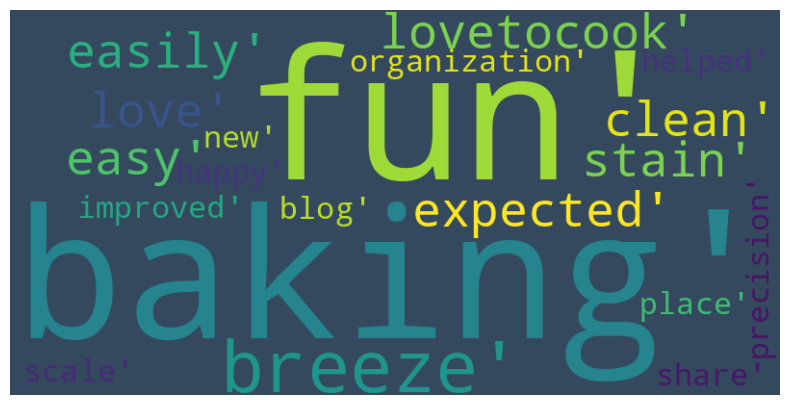

In [55]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Crea un objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='#34495E').generate(str(lista[0:2]))
# Configura el tamaño de la figura de Matplotlib
plt.figure(figsize=(10, 5))

# Muestra el gráfico de nube de palabras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Oculta los ejes
plt.show()


## Topicos para el sentimientos negativo.

In [59]:
count = CountVectorizer(stop_words='english', max_df = .1, max_features= 5000)
df_H_neg = df_H[df_H["Sentimiento_Marca"]=="negativa"]
count_neg = count.fit_transform(df_H_neg["Tweet"].values)
#n_components= 10 para decirle que cree 10 topicos.
lda = LatentDirichletAllocation(n_components= 10, random_state=123, learning_method='batch')
topics_neg = lda.fit_transform(count_neg)
#n_palabras_top va a ser usada para la cantidad de palabras a traer de las listas.
n_palabras_top = 10
nombres_caracterisiticos = count.get_feature_names_out()
lista=[]
for topics_idx, topics in enumerate(lda.components_):
  print(f"Palabra Top N°{topics_idx+1}")
  lista.append([nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]])
  print(" ".join( [nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]]))

Palabra Top N°1
family fun simple makes hate thought scratches scratch durable easily
Palabra Top N°2
hate hatedishes dishes doing fun thought scratches scratch durable easily
Palabra Top N°3
overrated price does expected feel fun hate scratches scratch durable
Palabra Top N°4
fun hate thought durable scratches scratch easily hasn issues badexperience
Palabra Top N°5
kids passion disaster mess allies best fun hate thought scratches
Palabra Top N°6
fun hate thought durable scratches scratch easily hasn issues badexperience
Palabra Top N°7
utensil supposed strange confusion use fun hate thought scratches scratch
Palabra Top N°8
hasn issues badexperience quality experience thought durable scratches scratch easily
Palabra Top N°9
family fun chaotic especially hate thought scratches scratch durable easily
Palabra Top N°10
fun hate thought durable scratches scratch easily hasn issues badexperience


### Ahora que tenemos los topicos, vamos a crear un gráfico para presentar a los topicos negativos.

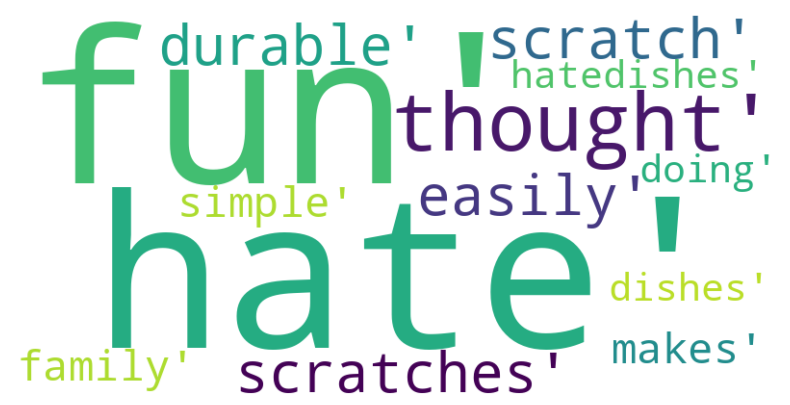

In [61]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(str(lista[0:2]))
# Configura el tamaño de la figura de Matplotlib
plt.figure(figsize=(10, 5))

# Muestra el gráfico de nube de palabras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Oculta los ejes
plt.show()

## Topicos para el sentimientos positivos.

In [67]:
#Como el dataset positivo era pequeño
#tuvimos que subir el valor de max_df.
count = CountVectorizer(stop_words='english', max_df = .5, max_features= 5000)
df_H_pos = df_H[df_H["Sentimiento_Marca"] =="Positiva"]
count_pos = count.fit_transform(df_H_pos["Tweet"].values)
#n_components= 10 para decirle que cree 10 topicos.
lda = LatentDirichletAllocation(n_components= 10, random_state=123, learning_method='batch')
topics_neg = lda.fit_transform(count_pos)
#n_palabras_top va a ser usada para la cantidad de palabras a traer de las listas.
n_palabras_top = 10
nombres_caracterisiticos = count.get_feature_names_out()
lista=[]
for topics_idx, topics in enumerate(lda.components_):
  print(f"Palabra Top N°{topics_idx+1}")
  lista.append([nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]])
  print(" ".join( [nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]]))

Palabra Top N°1
casserole versatile kitchen dish essential addition sturdy like easytoclean easy
Palabra Top N°2
easytoclean clean like easy technique favorite steaming sure quality left
Palabra Top N°3
steaming technique favorite easytoclean clean like easy sure quality left
Palabra Top N°4
easytoclean clean like easy technique favorite steaming sure quality left
Palabra Top N°5
easytoclean clean like easy technique favorite steaming sure quality left
Palabra Top N°6
easytoclean clean like easy technique favorite steaming sure quality left
Palabra Top N°7
easytoclean clean like easy technique favorite steaming sure quality left
Palabra Top N°8
easytoclean clean like easy technique favorite steaming sure quality left
Palabra Top N°9
impressed sure quality left expecting easytoclean clean like easy technique
Palabra Top N°10
easytoclean clean like easy technique favorite steaming sure quality left


### Ahora que tenemos los topicos, vamos a crear un gráfico para presentar a los topicos positivos.

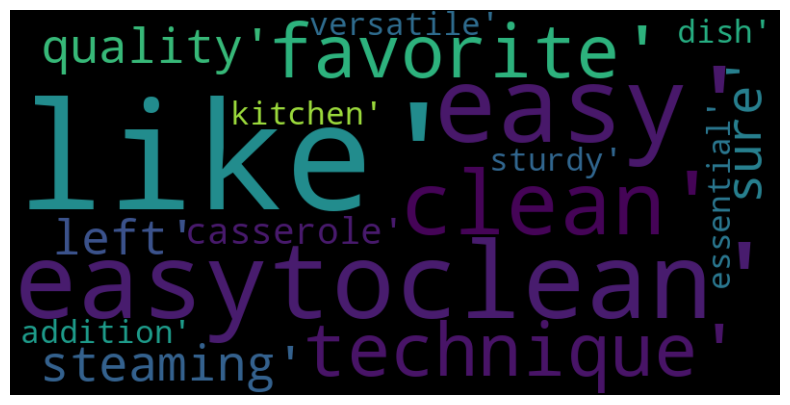

In [68]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(str(lista[0:3]))
# Configura el tamaño de la figura de Matplotlib
plt.figure(figsize=(10, 5))

# Muestra el gráfico de nube de palabras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Oculta los ejes
plt.show()

## topicos para el sentimiento Pesimo

In [69]:
#tuvimos que subir el valor de max_df.
count = CountVectorizer(stop_words='english', max_df = .5, max_features= 5000)
df_H_pes = df_H[df_H["Sentimiento_Marca"] =="Pesima"]
count_pes = count.fit_transform(df_H_pes["Tweet"].values)
#n_components= 10 para decirle que cree 10 topicos.
lda = LatentDirichletAllocation(n_components= 10, random_state=123, learning_method='batch')
topics_neg = lda.fit_transform(count_pos)
#n_palabras_top va a ser usada para la cantidad de palabras a traer de las listas.
n_palabras_top = 10
nombres_caracterisiticos = count.get_feature_names_out()
lista=[]
for topics_idx, topics in enumerate(lda.components_):
  print(f"Palabra Top N°{topics_idx+1}")
  lista.append([nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]])
  print(" ".join( [nombres_caracterisiticos[i] for i in topics.argsort() [:-n_palabras_top - 1:-1]]))

Palabra Top N°1
bad dessert burned baking bigdisappointment asian cuisine collapsed believe battlefield
Palabra Top N°2
believe badpurchase collapsed battlefield defeated bread covered culinaryexperiment considering cake
Palabra Top N°3
covered defeated bread believe badpurchase collapsed battlefield culinaryexperiment considering cake
Palabra Top N°4
believe badpurchase collapsed battlefield defeated bread covered culinaryexperiment considering cake
Palabra Top N°5
believe badpurchase collapsed battlefield defeated bread covered culinaryexperiment considering cake
Palabra Top N°6
believe badpurchase collapsed battlefield defeated bread covered culinaryexperiment considering cake
Palabra Top N°7
believe badpurchase collapsed battlefield defeated bread covered culinaryexperiment considering cake
Palabra Top N°8
believe badpurchase collapsed battlefield defeated bread covered culinaryexperiment considering cake
Palabra Top N°9
burn culinaryexperiment considering cake blender believe badp

### Ahora que tenemos los topicos, vamos a crear un gráfico para presentar a los topicos pesimos.

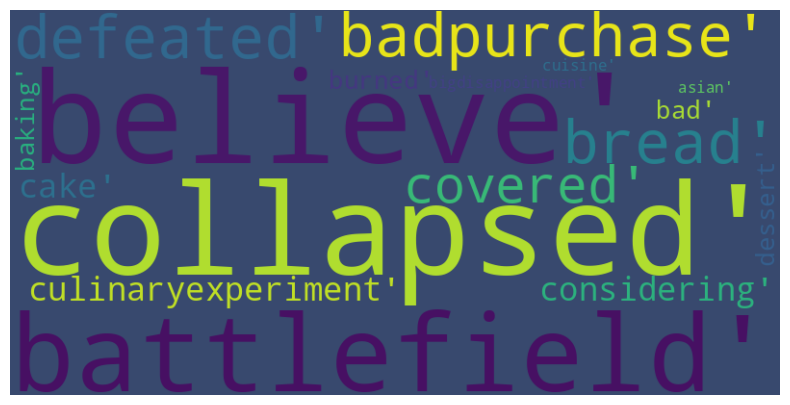

In [73]:
wordcloud = WordCloud(width=800, height=400, background_color='#38496E').generate(str(lista[0:3]))
# Configura el tamaño de la figura de Matplotlib
plt.figure(figsize=(10, 5))

# Muestra el gráfico de nube de palabras
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Oculta los ejes
plt.show()

### Este análisis muestra que la marca H tiene una gran aceptacion en todo el país. Así como también con los tópicos muestra las palabras que más se repiten de acuerdo al sentimiento asociado, para poder estimar que les gusta o no de la marca H.  